# 04.3 Selection Bias: When Controlling Hurts

**Chapter**: 4 - Graphical Causal Models  
**Section**: 3 - Selection Bias  
**Facure Source**: 04-Graphical-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Collider Trap](#11-the-collider-trap)
   - 1.2 [Explaining Away](#12-explaining-away)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Collider Bias](#21-collider-bias)
   - 2.2 [Mediator Bias](#22-mediator-bias)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Collider Simulation](#31-collider-simulation)
   - 3.2 [Mediator Simulation](#32-mediator-simulation)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Selection bias is subtle and often introduced by well-meaning analysts who "control for everything." Understanding this separates sophisticated causal thinkers.

### 1.1 The Collider Trap

Facure's example: **Education → Investments ← Wage**

- Education and Wage are **independent** causes of Investments
- Investments is a **collider**
- If we condition on Investments, we CREATE a spurious link between Education and Wage

**The trap**: It seems sensible to "control for" investment behavior when studying education → wage. But this introduces bias!

### 1.2 Explaining Away

**Intuition**: Among people with the same investment level:
- If someone has high education but low investments, their wage must be LOW (to explain the investment level)
- If someone has low education but high investments, their wage must be HIGH

This creates a **negative** spurious correlation between education and wage.

★ Insight ─────────────────────────────────────
- Colliders are **closed** by default (no bias)
- Conditioning on colliders **opens** them (creates bias)
- Selection bias can often be "fixed" by doing nothing
- We are biased toward action—avoid the temptation!
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Collider Bias

**Structure**: T → C ← Y

**Unconditionally**: T ⊥ Y (no association)

**Conditionally**: T ⫫̸ Y | C (association created!)

This extends to **descendants of colliders**:
- If D is caused by C, conditioning on D also opens the collider path

**Mathematical form**:
$$P(Y|T,C) \neq P(Y|T)$$

even when $P(Y|T) = P(Y)$ (unconditional independence).

### 2.2 Mediator Bias

**Structure**: T → M → Y (with direct effect T → Y)

Conditioning on the mediator M:
- Blocks the indirect path T → M → Y
- Only identifies the direct effect T → Y
- Misses the total effect

**When mediator bias matters**:
- If you want the **total effect**: Don't condition on M
- If you want the **direct effect**: Condition on M

But there's a subtlety: Conditioning on M can also introduce selection bias if M is affected by unobserved confounders.

---

## 3. Numeric Demonstration

### 3.1 Collider Simulation

In [2]:
# Simulate: Education → Investments ← Wage
# Education has TRUE effect = 5 on Wage
# Investments is a COLLIDER (caused by both Education and Wage)
np.random.seed(42)
n = 5000

TRUE_EFFECT = 5.0

# Treatment: Education (years)
education = np.random.normal(12, 3, n)

# Outcome: Wage (affected by education)
wage = 30 + TRUE_EFFECT * education + np.random.normal(0, 15, n)

# Collider: Investments (caused by BOTH education and wage)
investments = 0.5 * education + 0.3 * wage + np.random.normal(0, 5, n)

df = pd.DataFrame({
    'education': education,
    'wage': wage,
    'investments': investments,
})

print("COLLIDER SIMULATION")
print("="*50)
print(f"True effect of education: {TRUE_EFFECT}")
print(f"DAG: Education → Wage, Education → Investments, Wage → Investments")
print(f"Investments is a COLLIDER")

COLLIDER SIMULATION
True effect of education: 5.0
DAG: Education → Wage, Education → Investments, Wage → Investments
Investments is a COLLIDER


In [3]:
# Correct estimate: Don't control for collider
correct_model = sm.OLS(df['wage'], sm.add_constant(df['education'])).fit()

# WRONG: Control for collider
biased_model = sm.OLS(df['wage'], sm.add_constant(df[['education', 'investments']])).fit()

print("COLLIDER BIAS DEMONSTRATION")
print("="*60)
print(f"True effect:              {TRUE_EFFECT:.2f}")
print(f"Correct (no collider):    {correct_model.params['education']:.2f}")
print(f"Biased (with collider):   {biased_model.params['education']:.2f}")
print("-"*60)
print(f"Bias from collider:       {biased_model.params['education'] - TRUE_EFFECT:.2f}")
print("\nControlling for collider INTRODUCES bias!")

COLLIDER BIAS DEMONSTRATION
True effect:              5.00
Correct (no collider):    4.99
Biased (with collider):   1.98
------------------------------------------------------------
Bias from collider:       -3.02

Controlling for collider INTRODUCES bias!


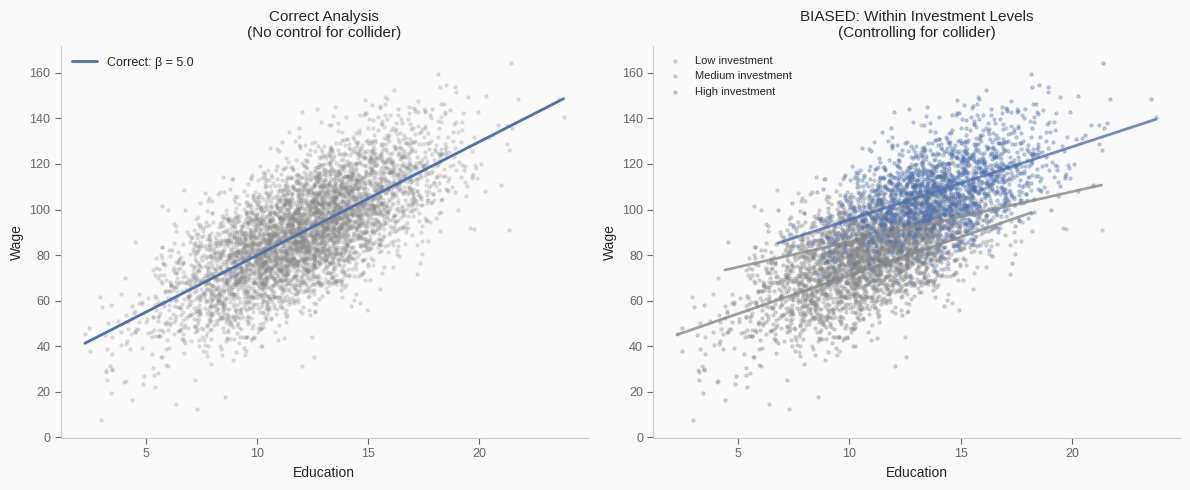


Within each investment level, the education-wage slope is FLATTER.
This is 'explaining away': given fixed investments, high education implies lower wage.


In [4]:
# Visualize "explaining away"
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Left: Overall relationship (correct)
ax = axes[0]
ax.scatter(df['education'], df['wage'], alpha=0.2, s=5, c=TUFTE_PALETTE['secondary'])
x_line = np.linspace(df['education'].min(), df['education'].max(), 100)
ax.plot(x_line, correct_model.params['const'] + correct_model.params['education'] * x_line,
        color=TUFTE_PALETTE['treatment'], linewidth=2, label=f'Correct: β = {correct_model.params["education"]:.1f}')
ax.set_xlabel('Education')
ax.set_ylabel('Wage')
ax.set_title('Correct Analysis\n(No control for collider)')
ax.legend(frameon=False)

# Right: Within investment tertiles (biased by explaining away)
ax = axes[1]
df['inv_tertile'] = pd.qcut(df['investments'], 3, labels=['Low', 'Medium', 'High'])
colors = {'Low': TUFTE_PALETTE['control'], 'Medium': TUFTE_PALETTE['secondary'], 'High': TUFTE_PALETTE['treatment']}

for tertile in ['Low', 'Medium', 'High']:
    subset = df[df['inv_tertile'] == tertile]
    ax.scatter(subset['education'], subset['wage'], alpha=0.3, s=5, 
               c=colors[tertile], label=f'{tertile} investment')
    # Regression within tertile
    model = sm.OLS(subset['wage'], sm.add_constant(subset['education'])).fit()
    x_line = np.linspace(subset['education'].min(), subset['education'].max(), 100)
    ax.plot(x_line, model.params['const'] + model.params['education'] * x_line,
            color=colors[tertile], linewidth=2, alpha=0.8)

ax.set_xlabel('Education')
ax.set_ylabel('Wage')
ax.set_title('BIASED: Within Investment Levels\n(Controlling for collider)')
ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()

print("\nWithin each investment level, the education-wage slope is FLATTER.")
print("This is 'explaining away': given fixed investments, high education implies lower wage.")

### 3.2 Mediator Simulation

In [5]:
# Simulate: Education → White Collar Job → Wage
# Education has direct AND indirect effects on Wage
np.random.seed(42)
n = 5000

DIRECT_EFFECT = 3.0  # Direct: Education → Wage
INDIRECT_EFFECT = 2.0  # Through mediator: Education → Job → Wage
TOTAL_EFFECT = DIRECT_EFFECT + INDIRECT_EFFECT

# Treatment: Education
education = np.random.normal(14, 3, n)

# Mediator: White collar job (probability increases with education)
prob_whitecollar = 1 / (1 + np.exp(-0.5 * (education - 14)))
whitecollar = np.random.binomial(1, prob_whitecollar, n)

# Outcome: Wage (affected by education directly AND through job)
wage = 30 + DIRECT_EFFECT * education + 10 * whitecollar + np.random.normal(0, 10, n)
# Note: The indirect effect through education→job→wage contributes when education increases job probability

df_med = pd.DataFrame({
    'education': education,
    'whitecollar': whitecollar,
    'wage': wage,
})

print("MEDIATOR SIMULATION")
print("="*50)
print(f"Direct effect:   {DIRECT_EFFECT}")
print(f"Indirect effect: ~{INDIRECT_EFFECT} (via white collar job)")
print(f"Total effect:    ~{TOTAL_EFFECT}")

MEDIATOR SIMULATION
Direct effect:   3.0
Indirect effect: ~2.0 (via white collar job)
Total effect:    ~5.0


In [6]:
# Total effect: Don't control for mediator
total_model = sm.OLS(df_med['wage'], sm.add_constant(df_med['education'])).fit()

# Direct effect: Control for mediator
direct_model = sm.OLS(df_med['wage'], sm.add_constant(df_med[['education', 'whitecollar']])).fit()

print("MEDIATOR ANALYSIS")
print("="*60)
print(f"Total effect (no mediator control):  {total_model.params['education']:.2f}")
print(f"Direct effect (mediator controlled): {direct_model.params['education']:.2f}")
print(f"Implied indirect effect:             {total_model.params['education'] - direct_model.params['education']:.2f}")
print("-"*60)
print("\nIf you want TOTAL effect, don't control for mediator!")
print("Controlling for mediator gives DIRECT effect only.")

MEDIATOR ANALYSIS
Total effect (no mediator control):  4.00
Direct effect (mediator controlled): 3.04
Implied indirect effect:             0.96
------------------------------------------------------------

If you want TOTAL effect, don't control for mediator!
Controlling for mediator gives DIRECT effect only.


---

## 4. Implementation

```python
# Rule: Identify colliders BEFORE analysis
# Draw your DAG first!

# If variable is a collider: DO NOT control for it
model = sm.OLS(outcome, treatment)  # Collider omitted

# If variable is a confounder: DO control for it
model = sm.OLS(outcome, [treatment, confounder])

# If variable is a mediator:
# - For total effect: DO NOT control
# - For direct effect: DO control (with caveats)

# Using DoWhy to check
from dowhy import CausalModel

model = CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    common_causes=['X'],  # Confounders
    # Do NOT include colliders here!
)
```

---

## 5. Interview Appendix

**Q1 (Netflix, Spotify)**: *"What is selection bias? How does it differ from confounding?"*

<details><summary>Solution</summary>

**Confounding**: Common **cause** of treatment and outcome
- DAG: X → T, X → Y
- Solution: Control for X

**Selection bias**: Common **effect** of treatment and outcome (collider)
- DAG: T → C ← Y
- Solution: Do NOT control for C

**Key difference**:
- Confounding exists without any conditioning; must be controlled
- Selection bias is **created** by conditioning on a collider; avoid it by not controlling

**Example**:
- Confounding: Intelligence → Education, Intelligence → Wage
- Selection bias: Education → Hollywood Success ← Looks (conditioning on success creates spurious education-looks correlation)

</details>

**Q2**: *"What is 'explaining away'? Give an example."*

<details><summary>Solution</summary>

**Explaining away**: When knowing the value of a common effect creates spurious correlation between its causes.

**Classic example**: Admission to a selective university
- Causes: Academic ability, Athletic ability
- Effect (collider): Admission

Among **admitted students only**:
- If someone is academically average but admitted, they must be athletically exceptional
- If someone is athletically average but admitted, they must be academically exceptional
- This creates **negative correlation** between academics and athletics among admitted students

**In the population**: Academics and athletics are likely uncorrelated (or even slightly positive). But conditioning on admission (collider) creates negative correlation.

</details>

**Q3 (Stripe, Airbnb)**: *"Your colleague suggests controlling for customer lifetime value when estimating the effect of a marketing campaign on purchases. What's wrong with this?"*

<details><summary>Solution</summary>

**The problem**: Customer lifetime value (LTV) is likely a **collider**.

**DAG**:
- Marketing → Purchases
- Marketing → LTV (marketing increases engagement)
- Purchases → LTV (purchases directly contribute to LTV)

So: Marketing → LTV ← Purchases

**Controlling for LTV** opens this collider path:
- Among customers with same LTV, those who received marketing must have made fewer purchases (to achieve same LTV)
- This creates **negative bias** on the marketing effect

**Correct approach**:
1. Don't control for LTV
2. Control for **pre-treatment** variables only (prior purchase history, demographics)
3. LTV can be an **outcome**, not a control

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 4.

[^2]: Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.

[^3]: Elwert, F., & Winship, C. (2014). Endogenous selection bias: The problem of conditioning on a collider variable. *Annual Review of Sociology*, 40, 31-53.